![UTKFace database](https://susanqq.github.io/UTKFace/icon/samples.png)

In this exercise, we will try implement an Autoencoder for encoding faces. We will use the [UTKFace database](https://susanqq.github.io/UTKFace/) of face images for training our autoencoder.

---



Connect the Notebook to a Google Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_folder = '/content/drive/MyDrive/Exercise09_autoencoders/'

Mounted at /content/drive


#Dataset

In [ ]:
import shutil
shutil.copyfile(gdrive_folder + 'UTKFace.tar.gz', 'UTKFace.tar.gz')
!rm -r UTKFace
!ls
!tar -xf UTKFace.tar.gz
!ls

rm: cannot remove 'UTKFace': No such file or directory
drive  sample_data  UTKFace.tar.gz
drive  sample_data  UTKFace  UTKFace.tar.gz


We load the images in a format usable for the neural network

In [ ]:
import numpy as np
from PIL import Image, ImageOps
import os

In [ ]:
WIDTH=64
HEIGHT=64
CHANNELS=3

In [ ]:
# Load an image, resize it to WIDTHxHEIGHT and return it as a numpy tensor 
# with shape (1,WIDTH,HEIGHT,3)
def load_image(fname):

  # load image from disk as a Pillow object
  img=Image.open(fname)
  if img.mode!='RGB':
    img=img.convert('RGB')

  # resize image without changing the aspect ratio
  w, h = img.size
  if w/WIDTH > h/HEIGHT:
    new_width=WIDTH
    new_height=int(new_width*h/w)
  else:
    new_height=HEIGHT
    new_width=int(new_height*w/h)
  img = img.resize((new_width, new_height))

  # eventually pad the resized image to WIDTH x HEIGHT pixels
  pad_left=(WIDTH-new_width)//2
  pad_top=(HEIGHT-new_height)//2
  pad_right=WIDTH-new_width-pad_left
  pad_bottom=HEIGHT-new_height-pad_top
  img = ImageOps.expand(img, (pad_left, pad_top, pad_right, pad_bottom))

  # convert to numpy array
  a=np.array(img, dtype=np.float32)/255.0
  return a.reshape((1, WIDTH, HEIGHT, CHANNELS))


In [ ]:
# Load images from a folder, and return a tensor X containing the images
def load_folder_images(folder):
  X=[] # empty list that will contain the images
  names=os.listdir(folder)
  count=0

  # loop over JPEG images in folder
  for name in names:
    ext = os.path.splitext(name)[1].lower()
    if ext!='.jpg' and ext!='.jpeg':
      continue
    path=os.path.join(folder, name)

    img=load_image(path)  # load, resize and convert image to numpy array
    X.append(img)         # append the numpy array
    count += 1

    if count % 100 == 0:  # print each 100 images
      print('Loaded', count, 'images.')
  
  print('Finished. Loaded', count, 'images.')
  X=np.concatenate(X)     # concatenate all the numpy arrays
  return X

In [ ]:
# Load the dataset files
X=load_folder_images('UTKFace')

In [ ]:
X.shape

(23708, 64, 64, 3)

In [ ]:
X.min(), X.max()

(0.0, 1.0)

In [ ]:
# Save in HDF5 format
import h5py

f=h5py.File(gdrive_folder + 'data.h5', 'w')
f.create_dataset('X', data=X)
f.close()

This code reloads the previously saved dataset from the HDF5 file:

In [ ]:
import numpy as np
import h5py

f=h5py.File(gdrive_folder + 'data.h5', 'r')
X=f['X'][:]
f.close()

This code can be used to show an image:

In [ ]:
from matplotlib import pyplot as plt
def show_image(img):
  plt.imshow(img)

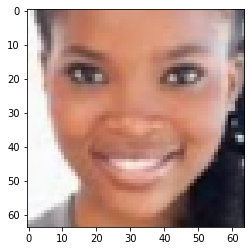

In [ ]:
show_image(X[10])

#Network architecture
Now let us build our encoder, decoder and autoencoder networks

In [ ]:
CODE_SIZE=128

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

encoder=Sequential(name='encoder')
encoder.add(Conv2D(128, kernel_size=5, strides=2, activation='relu', input_shape=(HEIGHT, WIDTH, CHANNELS)))
encoder.add(Conv2D(256, kernel_size=5, strides=2, activation='relu'))
encoder.add(Flatten())
encoder.add(Dense(1024, activation='relu'))
encoder.add(Dense(1024, activation='sigmoid'))
encoder.add(Dense(CODE_SIZE, activation='sigmoid'))
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       819456    
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              44303360  
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                                 
Total params: 46,313,344
Trainable params: 46,313,344
Non-t

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2DTranspose, Flatten, Reshape

decoder=Sequential(name='decoder')
decoder.add(Dense(1024, activation='sigmoid', input_shape=(CODE_SIZE,)))
decoder.add(Dense(1024, activation='relu'))
decoder.add(Dense(43264, activation='relu'))
decoder.add(Reshape((13,13,256)))
decoder.add(Conv2DTranspose(128, kernel_size=5, strides=2, activation='relu'))
decoder.add(Conv2DTranspose(128, kernel_size=5, strides=2, activation='relu'))
decoder.add(Conv2DTranspose(3, kernel_size=4, activation='sigmoid'))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              132096    
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 43264)             44345600  
                                                                 
 reshape_1 (Reshape)         (None, 13, 13, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 29, 29, 128)      819328    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 61, 61, 128)      409728    
 ranspose)                                                 

In [ ]:
model=Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 128)               46313344  
                                                                 
 decoder (Sequential)        (None, 64, 64, 3)         46762499  
                                                                 
Total params: 93,075,843
Trainable params: 93,075,843
Non-trainable params: 0
_________________________________________________________________


#Network train
Now we will compile the model, using the Mean Square Error loss function:


In [ ]:
model.compile(optimizer='rmsprop', loss='mse')
encoder.compile(optimizer='rmsprop', loss='mse')
decoder.compile(optimizer='rmsprop', loss='mse')


Now we train and save the network:

In [ ]:
for i in range(50):
  print('i=',i)
  model.fit(X, X, epochs=10)
  model.save(gdrive_folder + 'autoencoder.model')
  encoder.save(gdrive_folder + 'encoder.model')
  decoder.save(gdrive_folder + 'decoder.model')
print('Finished')

#Network validation
Load the model:


In [ ]:
from keras.models import load_model

model=load_model(gdrive_folder + 'autoencoder_final.model')
# Extract the encoder and decoder from the layers of the autoencoder, so as to
# continue sharing the weights
encoder=model.layers[0]
decoder=model.layers[1]
print('Loaded')

Loaded


Let us test our autoencoder

In [ ]:
X1=model.predict(X[:100])

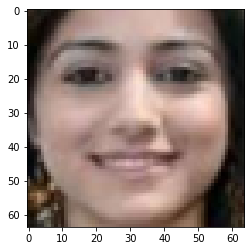

In [ ]:
i=9
show_image(X[i])


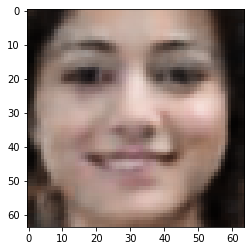

In [ ]:
show_image(X1[i])

Now we try to *generate* a random face:

[0.71743303 0.17907191 0.15391472 0.71293489 0.15263433 0.90398397
 0.4611627  0.38438716 0.50662495 0.6931142 ]


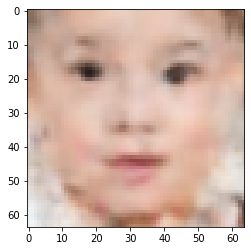

In [ ]:
yr=np.random.random((1, CODE_SIZE))
xr=decoder.predict(yr)
print(yr[0,:10])
show_image(xr[0])

Now we try to mix two faces:

Original face 1


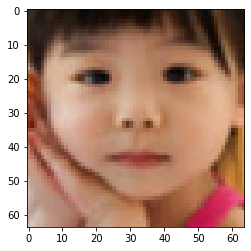

In [ ]:
i=17
j=12
print('Original face 1')
show_image(X[i])

Original face 2


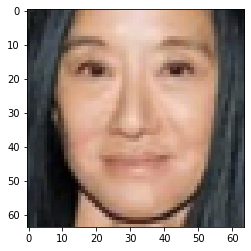

In [ ]:
print('Original face 2')
show_image(X[j])

In [ ]:
y=encoder.predict(X[:100])

Mixed image


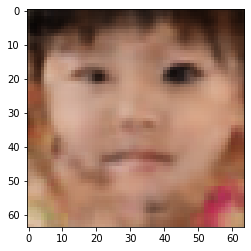

In [ ]:
rate=0.9
mix=(y[i] * rate + y[j] * (1-rate))
Xmix=decoder.predict(mix.reshape((1,CODE_SIZE)))
print('Mixed image')
show_image(Xmix[0])

#A new task
We can finetune the autoencoder to address a new task, like image colorization.

We convert the color images to gray-scale, then we train the autoencoder to invert this operation, which is not trivial!

Similarly, the autoencoder can be trained to denoise the images or to inpaint a small part of the image.

In [ ]:
X_new = np.mean(X, -1)
print(X_new.shape)
X_new = np.stack((X_new, X_new, X_new), -1)
print(X_new.shape)

(23711, 64, 64)
(23711, 64, 64, 3)


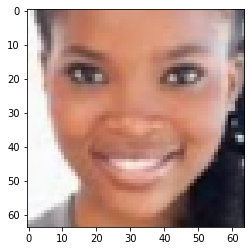

In [ ]:
show_image(X[10])

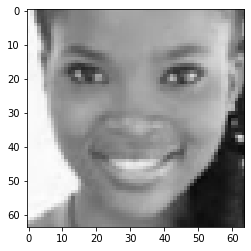

In [ ]:
show_image(X_new[10])

In [ ]:
for i in range(50):
  print('i=',i)
  model.fit(X_new, X, epochs=10)
  model.save(gdrive_folder + 'autoencoder.model')
  encoder.save(gdrive_folder + 'encoder.model')
  decoder.save(gdrive_folder + 'decoder.model')
print('Finished')